# Working with H3 in Vgrid DGGS

[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opengeoshub/vgrid/blob/main/docs/notebooks/01_h3.ipynb)
[![image](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/opengeoshub/vgrid/HEAD?filepath=docs/notebooks/01_h3.ipynb)
[![image](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/opengeoshub/vgrid/blob/main/docs/notebooks/01_h3.ipynb)
[![image](https://jupyterlite.rtfd.io/en/latest/_static/badge.svg)](https://demo.gishub.vn/lab/index.html?path=notebooks/vgrid/01_h3.ipynb)

Full Vgrid DGGS documentation is available at [vgrid document](https://vgrid.gishub.vn).

To work with Vgrid DGGS directly in GeoPandas and Pandas, please use [vgridpandas](https://pypi.org/project/vgridpandas/). Full Vgridpandas DGGS documentation is available at [vgridpandas document](https://vgridpandas.gishub.vn).

To work with Vgrid DGGS in QGIS, install the [Vgrid Plugin](https://plugins.qgis.org/plugins/vgridtools/).

To visualize DGGS in Maplibre GL JS, try the [vgrid-maplibre](https://www.npmjs.com/package/vgrid-maplibre) library.

For an interactive demo, visit the [Vgrid Homepage](https://vgrid.vn).

## Install vgrid

In [1]:
# %pip install vgrid --upgrade

## latlon2h3

In [2]:
from vgrid.conversion.latlon2dggs import latlon2h3

lat = 10.775276
lon = 106.706797
res = 9
h3_id = latlon2h3(lat, lon, 10)
h3_id

'8a65b56628e7fff'

### H3 to Polygon

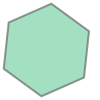

In [3]:
from vgrid.conversion.dggs2geo.h32geo import h32geo

h3_geo = h32geo(h3_id)
h3_geo

### H3 to GeoJSON        

In [3]:
from vgrid.conversion.dggs2geo.h32geo import h32geojson

h3_geojson = h32geojson(h3_id)
# h3_geojson

### Vector to H3

Processing features: 100%|██████████| 1/1 [00:00<00:00, 14.68it/s]


<Axes: >

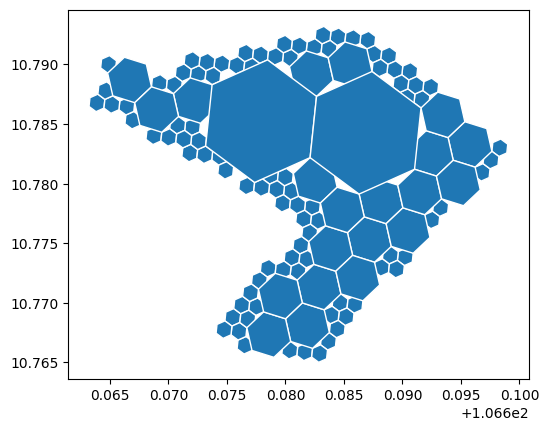

In [5]:
### H3 to Shapely Polygon
from vgrid.conversion.vector2dggs.vector2h3 import vector2h3

file_path = "https://raw.githubusercontent.com/opengeoshub/vopendata/main/shape/polygon2.geojson"
vector_to_h3 = vector2h3(
    file_path,
    compact=True,
    topology=True,
    resolution=10,
    predicate="intersects",
    output_format="gpd",
)

vector_to_h3.plot(edgecolor="white")

### H3 Compact

<Axes: >

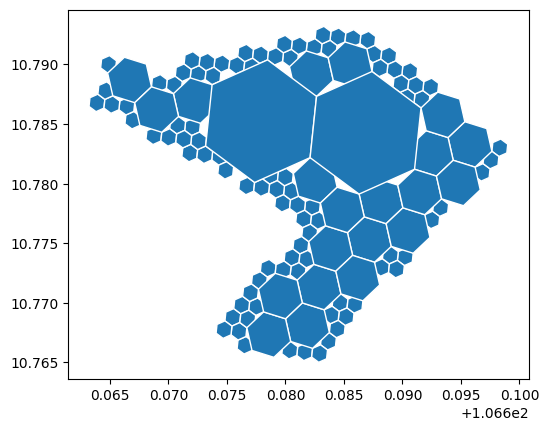

In [6]:
from vgrid.conversion.dggscompact.h3compact import h3compact

h3_compacted = h3compact(vector_to_h3, output_format="gpd")
h3_compacted.plot(edgecolor="white")

### H3 Expand

<Axes: >

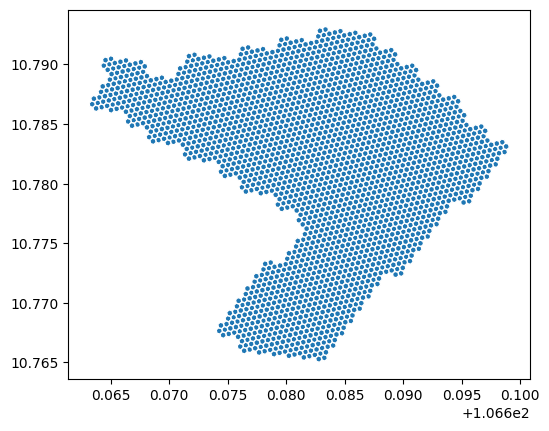

In [7]:
from vgrid.conversion.dggscompact.h3compact import h3expand

h3_expanded = h3expand(h3_compacted, resolution=11, output_format="gpd")
h3_expanded.plot(edgecolor="white")

### H3 Binning

Generating H3 DGGS: 100%|██████████| 1024/1024 [00:00<00:00, 7175.14it/s]


<Axes: >

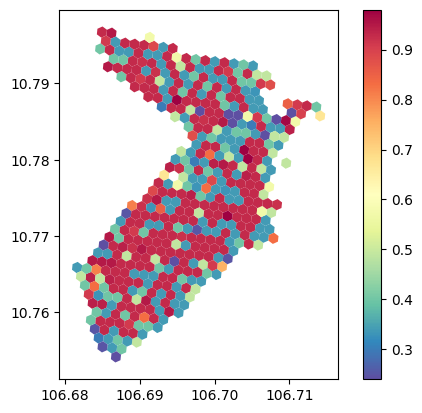

In [8]:
from vgrid.binning.h3bin import h3bin

file_path = (
    "https://raw.githubusercontent.com/opengeoshub/vopendata/main/csv/dist1_pois.csv"
)
stats = "majority"
h3_bin = h3bin(
    file_path,
    resolution=10,
    stats=stats,
    numeric_field="confidence",
    # category="category",
    output_format="gpd",
)
h3_bin.plot(
    column=stats,  # numeric column to base the colors on
    cmap="Spectral_r",  # color scheme (matplotlib colormap)
    legend=True,
    linewidth=0.2,  # boundary width (optional)
)

### Raster to H3

#### Download and open raster

WARNING [rasterio._env:368  open()] CPLE_AppDefined in PROJ: proj_create_from_database: Cannot find proj.db


rgb.tif already exists. Skip downloading. Set overwrite=True to overwrite.
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 240, 'height': 147, 'count': 3, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(2.6640125000199077e-06, 0.0, 106.708118755,
       0.0, -2.6640136054383103e-06, 10.812568272)}


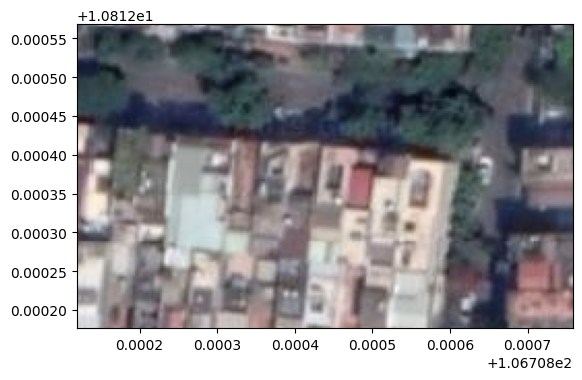

<Axes: >

In [9]:
from vgrid.utils.io import download_file
import rasterio
from rasterio.plot import show

raster_url = (
    "https://raw.githubusercontent.com/opengeoshub/vopendata/main/raster/rgb.tif"
)
raster_file = download_file(raster_url)
src = rasterio.open(raster_file, "r")
print(src.meta)
show(src)

#### Convert raster to H3

In [10]:
# %pip install folium

In [11]:
from vgrid.conversion.raster2dggs.raster2h3 import raster2h3

#### Convert to H3
raster_to_h3 = raster2h3(raster_file, output_format="gpd")
raster_to_h3.head()

# Visualize the output
import folium

m = folium.Map(tiles="CartoDB positron", max_zoom=28)

h3_layer = folium.GeoJson(
    raster_to_h3,
    style_function=lambda x: {
        "fillColor": f"rgb({x['properties']['band_1']}, {x['properties']['band_2']}, {x['properties']['band_3']})",
        "fillOpacity": 1,
        "color": "black",
        "weight": 0.5,
    },
    popup=folium.GeoJsonPopup(
        fields=["h3", "resolution", "band_1", "band_2", "band_3", "cell_area"],
        aliases=["H3 ID", "Resolution", "Band 1", "Band 2", "Band 3", "Area (m²)"],
        style="""
            background-color: white;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
    ),
).add_to(m)

m.fit_bounds(h3_layer.get_bounds())

# Display the map
m

Cell size: 0.08638527081938627 m2
Nearest H3 resolution determined: 15


Converting raster to H3: 100%|██████████| 3059/3059 [00:00<00:00, 6269.91 cells/s]


### H3 Generator

Generating H3 DGGS: 100%|██████████| 2/2 [00:00<00:00, 999.12it/s]


<Axes: >

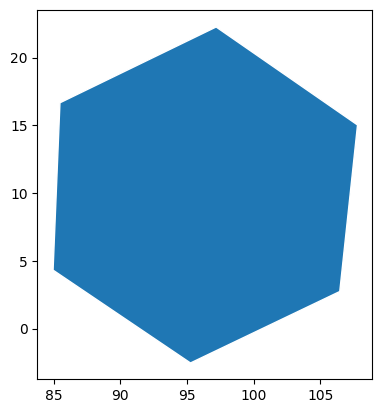

In [12]:
from vgrid.generator.h3grid import h3grid

# h3_grid = h3grid(resolution=0,fix_antimeridian = 'shift_west')
h3_grid = h3grid(
    resolution=0,
    bbox=[106.699007, 10.762811, 106.717674, 10.778649],
    output_format="gpd",
)
h3_grid.plot(edgecolor="white")
# h3_grid.to_crs('ESRI:53009').plot(edgecolor="white")

### H3 Inspect

In [13]:
from vgrid.stats.h3stats import h3inspect

resolution = 3
h3_inspect = h3inspect(resolution)
h3_inspect = h3_inspect[
    ~h3_inspect["crossed"]
]  # remove cells that cross the Antimeridian
h3_inspect.head()

Generating H3 DGGS: 100%|██████████| 41162/41162 [00:06<00:00, 6274.98 cells/s]


h3  resolution  center_lat  center_lon  avg_edge_len  \
0  830000fffffffff           3   79.243774   38.024416  68843.990170   
1  830001fffffffff           3   80.118133   34.269779  68959.671785   
2  830002fffffffff           3   79.248915   43.752678  69357.427250   
3  830003fffffffff           3   80.192303   40.496153  69494.752859   
4  830004fffffffff           3   78.291383   35.976646  68171.344007   

      cell_area  cell_perimeter  \
0  1.229263e+10   413063.941020   
1  1.233470e+10   413758.030713   
2  1.247975e+10   416144.563503   
3  1.253001e+10   416968.517157   
4  1.204928e+10   409028.064042   

                                            geometry  crossed  is_pentagon  \
0  POLYGON ((38.40265 78.62862, 40.9926 78.94864,...    False        False   
1  POLYGON ((34.90645 79.50578, 37.59652 79.85885...    False        False   
2  POLYGON ((43.80951 78.62667, 46.57082 78.89905...    False        False   
3  POLYGON ((40.75903 79.56831, 43.68502 79.87171...    False        False   
4  POLYGON ((36.42872 77.68575, 38.74177 78.01773...    False        False   

   norm_area       ipq       zsc  cvh  
0   0.992008  0.905357  0.951491  1.0  
1   0.995403  0.905410  0.951519  1.0  
2   1.007109  0.905581  0.951609  1.0  
3   1.011165  0.905638  0.951639  1.0  
4   0.972370  0.905034  0.951321  1.0

### H3 Normalized Area Histogram

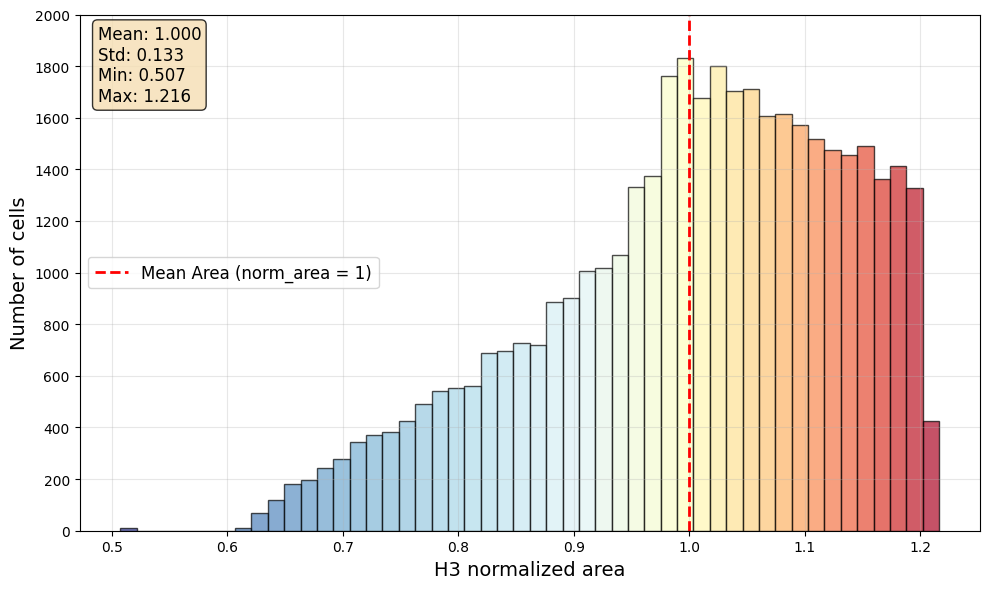

In [14]:
from vgrid.stats.h3stats import h3_norm_area_hist

h3_norm_area_hist(h3_inspect)

### Distribution of H3 Area Distortions

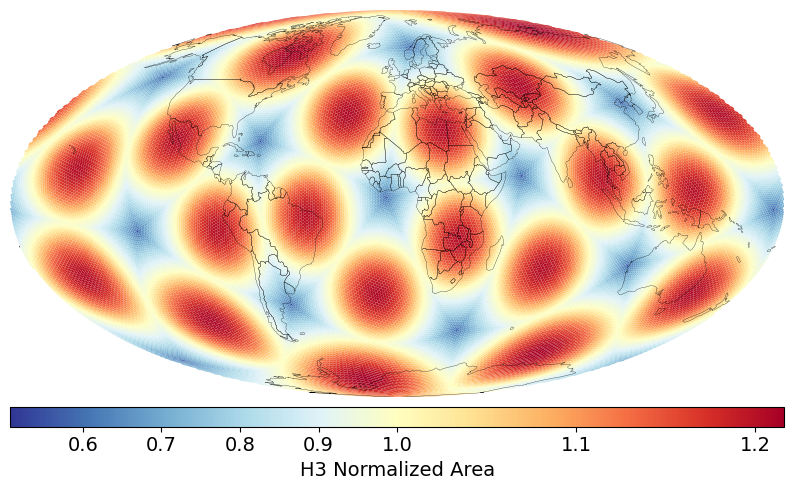

In [15]:
from vgrid.stats.h3stats import h3_norm_area

h3_norm_area(h3_inspect)

### H3 IPQ Compactness Histogram

Isoperimetric Inequality (IPQ) Compactness (suggested by [Osserman, 1978](https://sites.math.washington.edu/~toro/Courses/20-21/MSF/osserman.pdf)):

$$C_{IPQ} = \frac{4 \pi A}{p^2}$$
The range of the IPQ compactness metric is [0,1]. 

A circle represents the maximum compactness with a value of 1. 

As shapes become more irregular or elongated, their compactness decreases toward 0.


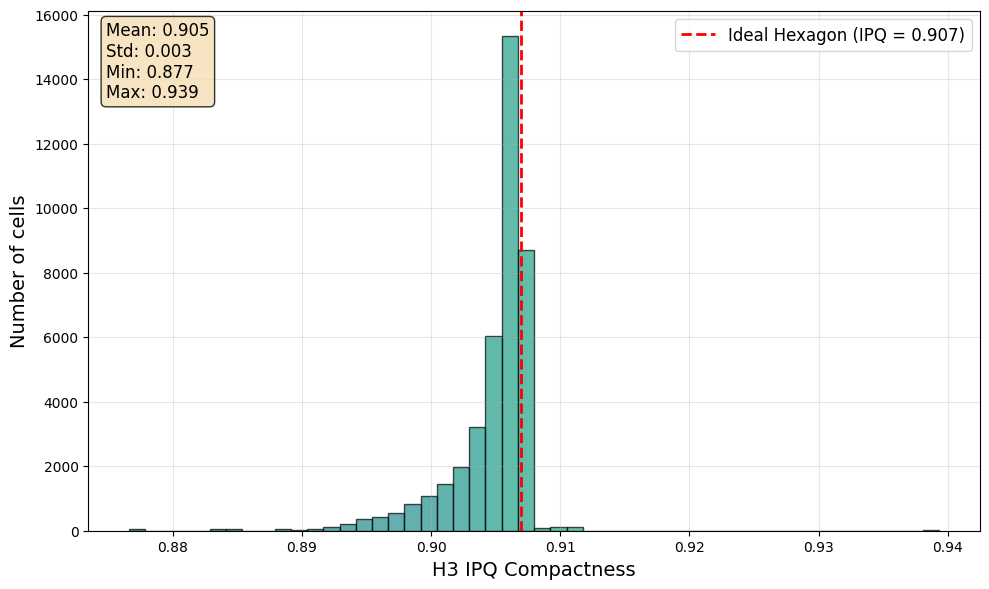

In [16]:
from vgrid.stats.h3stats import h3_compactness_ipq_hist

h3_compactness_ipq_hist(h3_inspect)

### Distribution of H3 IPQ Compactness

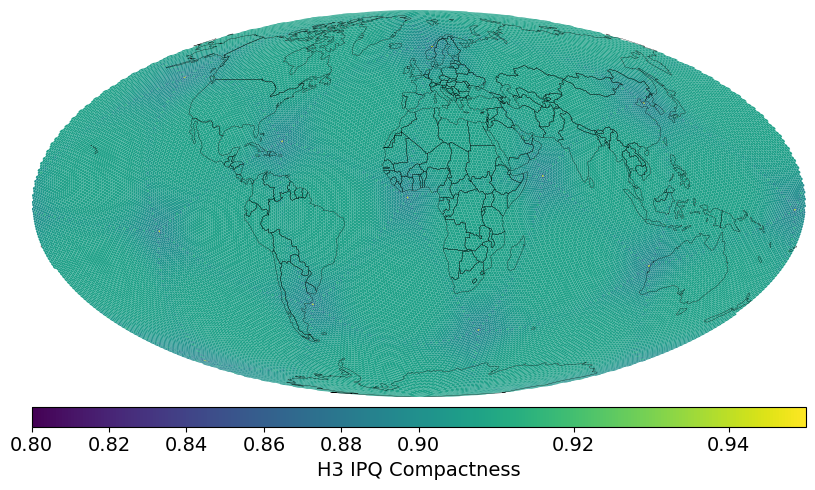

In [17]:
from vgrid.stats.h3stats import h3_compactness_ipq

h3_compactness_ipq(h3_inspect)

### H3 Convex hull Compactness Histogram:

$$C_{CVH} = \frac{A}{A_{CVH}}$$


The range of the convex hull compactness metric is [0,1]. 

As shapes become more concave, their convex hull compactness decreases toward 0.

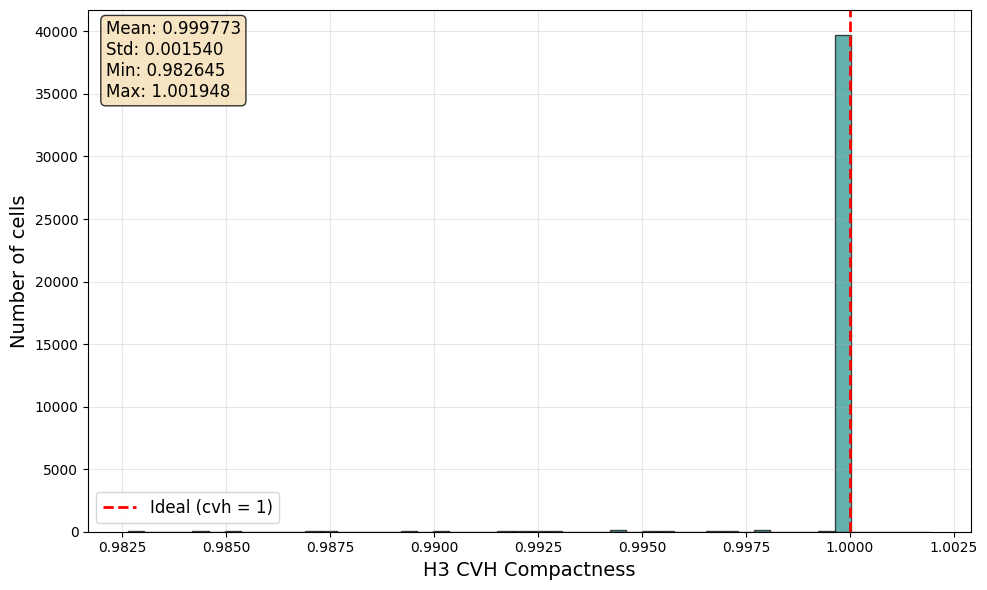

In [18]:
from vgrid.stats.h3stats import h3_compactness_cvh_hist

h3_compactness_cvh_hist(h3_inspect)

### Distribution of H3 Convex hull Compactness

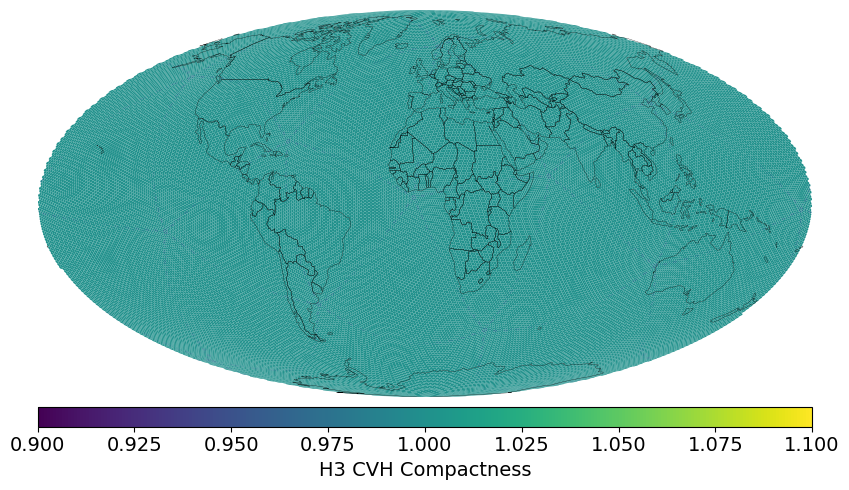

In [19]:
from vgrid.stats.h3stats import h3_compactness_cvh

h3_compactness_cvh(h3_inspect)

### H3 Statistics

Characteristic Length Scale (CLS - suggested by Ralph Kahn): the diameter of a spherical cap of the same cell's area

In [20]:
from vgrid.stats.h3stats import h3stats

h3_stats = h3stats("m")
h3_stats

resolution  number_of_cells  avg_edge_len_m    avg_area_m    min_area_m  \
0            0              122    1.281256e+06  4.357449e+12  2.562182e+12   
1            1              842    4.830568e+05  6.097884e+11  3.284346e+11   
2            2             5882    1.825130e+05  8.680178e+10  4.493090e+10   
3            3            41162    6.897922e+04  1.239343e+10  6.315472e+09   
4            4           288122    2.607176e+04  1.770348e+09  8.965824e+08   
5            5          2016842    9.854091e+03  2.529039e+08  1.277856e+08   
6            6         14117882    3.724533e+03  3.612906e+07  1.823875e+07   
7            7         98825162    1.406476e+03  5.161293e+06  2.604669e+06   
8            8        691776122    5.314140e+02  7.373276e+05  3.720480e+05   
9            9       4842432842    2.007861e+02  1.053325e+05  5.314719e+04   
10          10      33897029882    7.586378e+01  1.504750e+04  7.592318e+03   
11          11     237279209162    2.866390e+01  2.149643e+03  1.084609e+03   
12          12    1660954464122    1.083019e+01  3.070919e+02  1.549438e+02   
13          13   11626681248842    4.092010e+00  4.387027e+01  2.213481e+01   
14          14   81386768741882    1.546100e+00  6.267181e+00  3.162114e+00   
15          15  569707381193162    5.841690e-01  8.953116e-01  4.517305e-01   

      max_area_m  max_min_ratio         cls_m  
0   4.977807e+12       1.942800  2.358802e+06  
1   7.294869e+11       2.221102  8.813151e+05  
2   1.045998e+11       2.328015  3.324541e+05  
3   1.495077e+10       2.367325  1.256182e+05  
4   2.135987e+09       2.382366  4.747714e+04  
5   3.051443e+08       2.387940  1.794456e+04  
6   4.359211e+07       2.390082  6.782400e+03  
7   6.227446e+06       2.390878  2.563506e+03  
8   8.896352e+05       2.391184  9.689142e+02  
9   1.270907e+05       2.391297  3.662151e+02  
10  1.815582e+04       2.391341  1.384163e+02  
11  2.593689e+03       2.391357  5.231645e+01  
12  3.705269e+02       2.391363  1.977376e+01  
13  5.293242e+01       2.391366  7.473778e+00  
14  7.561774e+00       2.391367  2.824823e+00  
15  1.080253e+00       2.391367  1.067683e+00